Format: BMP
Ukuran: (500, 502)
Mode: RGB
Ukuran file  : 753054 bytes


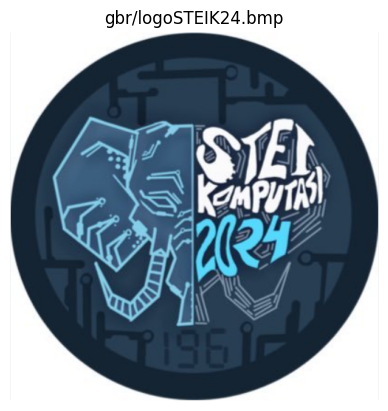

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np

# Path gambar yang ingin dibuka
image_path = "gbr/logoSTEIK24.bmp"  # nama file gambar

# Buka gambar
img = Image.open(image_path)

# Tampilkan info dasar
print("Format:", img.format)
print("Ukuran:", img.size)
print("Mode:", img.mode)
# Tampilkan ukuran file dalam byte
file_size = os.path.getsize(image_path)
print("Ukuran file  :", file_size, "bytes")

# Tampilkan gambar
plt.imshow(img)
plt.axis('off')  # Hilangkan sumbu
plt.title(image_path)
plt.show()

Contoh data RGB [0:2, 0:2]:
 [[[255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]]]


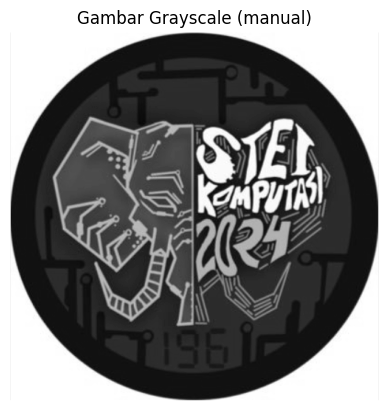

In [2]:
# Konversi ke array RGB
img_rgb = img.convert("RGB")
rgb_array = np.array(img_rgb)

# Tampilkan sebagian kecil matriks RGB
print("Contoh data RGB [0:2, 0:2]:\n", rgb_array[0:2, 0:2])

# Ubah ke grayscale menggunakan rumus manual
gray_array = 0.299 * rgb_array[:, :, 0] + \
             0.587 * rgb_array[:, :, 1] + \
             0.114 * rgb_array[:, :, 2]

# Konversi ke uint8 agar bisa ditampilkan/simpan sebagai citra
gray_array = gray_array.astype(np.uint8)

# Tampilkan grayscale
plt.imshow(gray_array, cmap='gray')
plt.title("Gambar Grayscale (manual)")
plt.axis('off')
plt.show()

In [3]:
print(gray_array)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [242 255 255 ... 255 255 242]
 ...
 [242 255 255 ... 255 255 242]
 [242 255 255 ... 255 255 242]
 [255 255 255 ... 255 255 255]]


Bin edges (jumlah 4): [0, 85, 170, 255]


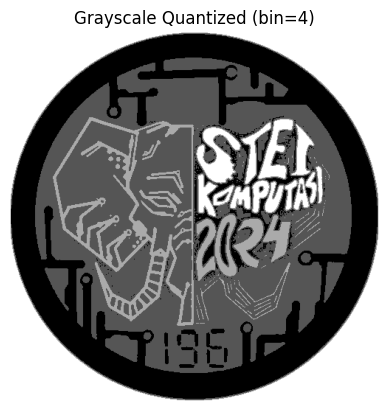

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [4]:
# 1. Function for generate bin points
def generate_bins(min_val=0, max_val=255, bin_count=2):
    bin_width = (max_val - min_val) / (bin_count - 1)
    bins = [round(min_val + i * bin_width) for i in range(bin_count)]
    bins[-1] = max_val
    return bins

# 2. function for quantization values of array_gray
def quantize_to_nearest_bin(array_gray: np.ndarray, bin_count: int) -> np.ndarray:
    bin_values = np.array(generate_bins(0, 255, bin_count))
    flat_gray = array_gray.flatten()
    distances = np.abs(flat_gray[:, None] - bin_values[None, :])
    nearest_indices = np.argmin(distances, axis=1)
    quantized_flat = bin_values[nearest_indices]
    quantized_array = quantized_flat.reshape(array_gray.shape).astype(np.uint8)
    return quantized_array

# 2. Generate bins
bin_count = 4  # bisa diganti 2, 3, 5, 7, dst 256
bin_edges = generate_bins(0, 255, bin_count)
print(f"Bin edges (jumlah {bin_count}):", bin_edges)

# 3. Kuantifikasi grayscale → array terkuantifikasi
# Kita butuh ubah bin_edges ke np.array dan tambahkan 1 karena digitize exclude last
quantized_array = quantize_to_nearest_bin(gray_array, bin_count)

# 4. Tampilkan hasil
plt.imshow(quantized_array, cmap='gray')
plt.title(f'Grayscale Quantized (bin={bin_count})')
plt.axis('off')
plt.show()

print(quantized_array)

In [5]:
import heapq
import json
from collections import Counter, namedtuple

# Node Structure for Huffman Tree
class Node(namedtuple("Node", ["symbol", "freq", "left", "right"])):
    def __lt__(self, other):  # dibutuhkan oleh heapq
        return self.freq < other.freq

# Build huffman tree from array
def build_huffman_tree(array):
    freq = Counter(array.flatten())
    heap = [Node(symbol=sym, freq=frq, left=None, right=None) for sym, frq in freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(symbol=None, freq=left.freq + right.freq, left=left, right=right)
        heapq.heappush(heap, merged)
    return heap[0] if heap else None

# Generate Huffman code from tree
def generate_huffman_codes(node, prefix="", codebook=None):
    if codebook is None:
        codebook = {}
    if node is not None:
        if node.symbol is not None:
            codebook[node.symbol] = prefix
        else:
            generate_huffman_codes(node.left, prefix + "0", codebook)
            generate_huffman_codes(node.right, prefix + "1", codebook)
    return codebook

# save JSON
def save_huffman_to_json(codebook, filename):
    codebook_str = {int(k): v for k, v in codebook.items()}
    with open(filename, "w") as f:
        json.dump(codebook_str, f, indent=4)
    print(f"Huffman codes disimpan ke '{filename}'")


# Pastikan 'quantized_array' sudah ada dari langkah sebelumnya
# Misalnya:
# quantized_array = quantize_to_nearest_bin(gray_array, bin_count=5)

# Bangun pohon dan kode Huffman
tree = build_huffman_tree(quantized_array)
codebook = generate_huffman_codes(tree)

# Tampilkan kode Huffman
print("Kode Huffman:")
for val, code in codebook.items():
    print(f"{val} : {code}")

# Simpan ke file .json
save_huffman_to_json(codebook,"huffman_codes.json")

Kode Huffman:
85 : 0
0 : 10
170 : 110
255 : 111
Huffman codes disimpan ke 'huffman_codes.json'


In [6]:
def calculate_huffman_efficiency(array, codebook):
    # Pastikan array numpy
    array = np.array(array)
    freq = Counter(array.flatten())

    # Total bit asli (8 bit per piksel)
    original_bits = array.size * 8

    # Total bit setelah kompresi Huffman
    compressed_bits = sum(freq[val] * len(codebook[val]) for val in freq)

    # Rasio dan efisiensi
    rasio = original_bits / compressed_bits
    efisiensi = (1 - (compressed_bits / original_bits)) * 100

    print(f"Total pixel            : {array.size}")
    print(f"Ukuran asli (bit)      : {original_bits}")
    print(f"Ukuran terkompresi     : {compressed_bits}")
    print(f"Rasio kompresi         : {rasio:.3f}")
    print(f"Efisiensi kompresi     : {efisiensi:.2f}%")

    return rasio, efisiensi

calculate_huffman_efficiency(quantized_array, codebook)

Total pixel            : 251000
Ukuran asli (bit)      : 2008000
Ukuran terkompresi     : 484989
Rasio kompresi         : 4.140
Efisiensi kompresi     : 75.85%


(4.140300089280376, 75.84716135458167)

In [7]:
unique_values = np.unique(gray_array)
print("Nilai unik:", unique_values)

# Jumlah nilai unik
jumlah_unik = unique_values.size
print("Jumlah nilai unik:", jumlah_unik)

Nilai unik: [ 16  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255]
Jumlah nilai unik: 237


In [8]:
from skimage.metrics import structural_similarity as ssim
score, _ = ssim(gray_array, quantized_array, full=True)
print("SSIM Score:", score)

SSIM Score: 0.6564456481600084


In [9]:
# Hitung nilai unik dan frekuensinya
values, counts = np.unique(quantized_array, return_counts=True)

# Gabungkan hasil sebagai pasangan nilai dan frekuensi
frequency_dict = dict(zip(values, counts))

print(frequency_dict)

{0: 68041, 85: 99985, 170: 20212, 255: 62762}


In [10]:
def encode_and_save_bin(array_gray: np.ndarray, huffman_dict: dict, output_path="bitdata.bin"):
    """
    Encode grayscale array using Huffman codes and save the bitstream as a binary .bin file.

    Parameters:
        array_gray (np.ndarray): Quantized grayscale image as 2D array of integers.
        huffman_dict (dict): Dictionary of Huffman codes (keys as string integers, values as bit strings).
        output_path (str): Output filename for the .bin file.
    """
    # 1. Flatten array and map each value to Huffman code
    flat = array_gray.flatten()
    bitstream = ''.join(huffman_dict[str(val)] for val in flat)

    # 2. Padding to make bitstream a multiple of 8
    padding_length = (8 - len(bitstream) % 8) % 8
    bitstream_padded = bitstream + '0' * padding_length

    # 3. Convert bitstream to bytes
    byte_array = bytearray()
    for i in range(0, len(bitstream_padded), 8):
        byte = bitstream_padded[i:i+8]
        byte_array.append(int(byte, 2))

    # 4. Write to .bin file
    with open(output_path, 'wb') as f:
        f.write(byte_array)

    print(f"Bitstream saved to {output_path} ({len(byte_array)} bytes, with {padding_length} bits of padding)")

huffman_dict = {
    "85": "0",
    "0": "10",
    "170": "110",
    "255": "111"
}

# Panggil fungsi
encode_and_save_bin(quantized_array, huffman_dict, output_path="bitdata.bin")


Bitstream saved to bitdata.bin (60624 bytes, with 3 bits of padding)
